In [37]:
import os
import sys
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torch.optim as optim
from itertools import product
import matplotlib.pyplot as plt
from torchvision import transforms
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../')))
# from models.cnn.cnn import CNNModel

In [38]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using GPU: MPS")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: MPS


### 2.1

In [39]:
def load_mnist_data(data_dir):
    def get_images_and_labels(split):
        images = []
        labels = []
        split_dir = os.path.join(data_dir, split)
        for folder in os.listdir(split_dir):
            folder_path = os.path.join(split_dir, folder)
            if os.path.isdir(folder_path):
                label = len(folder) 
                for img_name in os.listdir(folder_path):
                    img_path = os.path.join(folder_path, img_name)
                    img = Image.open(img_path).convert('L')  
                    images.append(img)
                    labels.append(label)
        return images, labels

    train_images, train_labels = get_images_and_labels('train')
    val_images, val_labels = get_images_and_labels('val')
    test_images, test_labels = get_images_and_labels('test')
    
    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)


class MultiMNISTDataset(Dataset):
    def __init__(self, images, labels, task_type='classification', transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.task_type = task_type  

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)

        if self.task_type == 'classification':
            label = torch.tensor(len(str(label)), dtype=torch.long) 

        elif self.task_type == 'regression':
            label = torch.tensor(float(len(str(label))), dtype=torch.float)

        return image, label
    
    
def train_model(model, train_loader, val_loader, optimizer, num_epochs=10, device='cpu'):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_accuracy = 0.0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the gradients
            
            # forward pass
            # outputs = model(images, return_feature_maps=False)
            outputs, _ = model(images) 
            
            # loss calculation
            loss = model.calculate_loss(outputs, labels)
            
            # back pass
            loss.backward()
            optimizer.step()
            
            # tracking loss
            running_loss += loss.item()

            if model.task_type == 'classification':
                running_accuracy += model.calculate_accuracy(outputs, labels) * labels.size(0)
                total += labels.size(0)

        avg_train_loss = running_loss / len(train_loader)

        if model.task_type == 'classification':
            avg_train_accuracy = running_accuracy / total
        
        
        model.eval()
        val_loss = 0.0
        val_accuracy = 0.0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                #fwd pass
                outputs, _ = model(images)
                loss = model.calculate_loss(outputs, labels)
                val_loss += loss.item()

                if model.task_type == 'classification':
                    val_accuracy += model.calculate_accuracy(outputs, labels) * labels.size(0)
                    total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)

        if model.task_type == 'classification':
            avg_val_accuracy = val_accuracy / total
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_accuracy:.4f}')
        else:
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')


### 2.2

In [8]:
# class CNNModel(nn.Module):
#     def __init__(self, num_classes=10, task_type='classification', dropout_rate=0.5, num_conv_layers=2):
#         super(CNNModel, self).__init__()
#         self.task_type = task_type
#         self.conv_layers = nn.ModuleList()
        
#         self.conv_layers.append(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1))

#         for i in range(1, num_conv_layers):
#             in_channels = 32 if i == 1 else 64
#             self.conv_layers.append(nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=1, padding=1))

#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.dropout = nn.Dropout(p=dropout_rate)

#         dummy_input = torch.randn(1, 1, 28, 28)
#         conv_out_size = self._get_conv_output(dummy_input)

#         self.fc1 = nn.Linear(conv_out_size, 128)
#         self.fc2 = nn.Linear(128, num_classes if task_type == 'classification' else 1)

#         self.classification_loss = nn.CrossEntropyLoss()
#         self.regression_loss = nn.MSELoss()

#     def _get_conv_output(self, x):
#         for conv in self.conv_layers:
#             x = self.pool(F.relu(conv(x)))
#         return x.numel()

#     def forward(self, x, return_feature_maps=False):
#         feature_maps = []  # To store intermediate feature maps

#         # Pass through convolutional layers
#         for conv in self.conv_layers:
#             x = self.pool(F.relu(conv(x)))
#             if return_feature_maps:
#                 feature_maps.append(x)  # Save the feature maps if flag is set

#         x = x.view(x.size(0), -1)  # Flatten the tensor
#         x = F.relu(self.fc1(x))
#         x = self.dropout(x)
        
#         if self.task_type == 'classification':
#             logits = self.fc2(x)
#             if return_feature_maps:
#                 return logits, feature_maps
#             return logits
#         else:
#             regression_output = self.fc2(x)
#             if return_feature_maps:
#                 return regression_output, feature_maps
#             return regression_output
        
#     def calculate_loss(self, outputs, labels):
#         if self.task_type == 'classification':
#             loss = self.classification_loss(outputs, labels)
#         else:
#             loss = self.regression_loss(outputs.squeeze(), labels.float())
#         return loss

#     def calculate_accuracy(self, outputs, labels):
#         if self.task_type == 'classification':
#             _, predicted = torch.max(outputs, 1)
#             correct = (predicted == labels).sum().item()
#             total = labels.size(0)
#             accuracy = correct / total
#             return accuracy
#         else:
#             return None


In [40]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=10, task_type='classification', dropout_rate=0.5, num_conv_layers=2):
        super(CNNModel, self).__init__()
        self.task_type = task_type
        self.conv_layers = nn.ModuleList()
        
        # initial Conv Layer
        self.conv_layers.append(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1))
        
        # additional conv layers (based on num_conv_layers)
        for i in range(1, num_conv_layers):
            in_channels = 32 if i == 1 else 64
            self.conv_layers.append(nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=1, padding=1))
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=dropout_rate)

        dummy_input = torch.randn(1, 1, 28, 28)
        conv_out_size = self._get_conv_output(dummy_input)

        self.fc1 = nn.Linear(conv_out_size, 128)
        self.fc2 = nn.Linear(128, num_classes if task_type == 'classification' else 1)

        self.classification_loss = nn.CrossEntropyLoss()
        self.regression_loss = nn.MSELoss()

    def _get_conv_output(self, x):
        for conv in self.conv_layers:
            x = self.pool(F.relu(conv(x)))
        return x.numel()

    def forward(self, x):
        feature_maps = []  # store intermediate feature maps
        
        # pass through each convolutional layer
        for conv in self.conv_layers:
            x = F.relu(conv(x))
            feature_maps.append(x) 
            x = self.pool(x) 
            
        # flatten the output
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        

        if self.task_type == 'classification':
            logits = self.fc2(x)
            return logits, feature_maps
        else:
            regression_output = self.fc2(x)
            return regression_output, feature_maps

    def calculate_loss(self, outputs, labels):
        if self.task_type == 'classification':
            loss = self.classification_loss(outputs, labels)
        else:
            loss = self.regression_loss(outputs.squeeze(), labels.float())
        return loss

    def calculate_accuracy(self, outputs, labels):
        if self.task_type == 'classification':
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels).sum().item()
            total = labels.size(0)
            accuracy = correct / total
            return accuracy
        else:
            return None

In [41]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


data_dir = '../../data/external/double_mnist'
(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = load_mnist_data(data_dir)

train_dataset = MultiMNISTDataset(train_images, train_labels, transform=transform)
val_dataset = MultiMNISTDataset(val_images, val_labels, transform=transform)
test_dataset = MultiMNISTDataset(test_images, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = CNNModel(task_type='classification')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
train_model(model, train_loader, val_loader, optimizer, num_epochs=10, device=device)


Epoch 1/10, Train Loss: 0.0247, Train Acc: 0.9953, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 2/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 3/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 4/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 5/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 6/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 7/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 8/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 9/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 10/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


### 2.3

Training classification model 1/16 with LR: 0.001, Dropout: 0.3, Layers: 2, Optimizer: adam
Epoch 1/10, Train Loss: 0.0187, Train Acc: 0.9975, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 2/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 3/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 4/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 5/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 6/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 7/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 8/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 9/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 10/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Training classification model 2/16 with LR: 0.001, Dropou

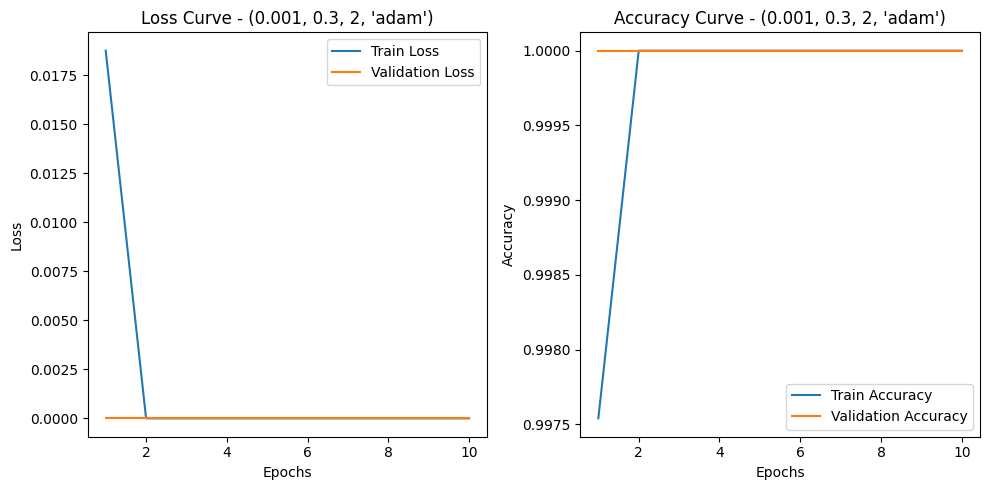

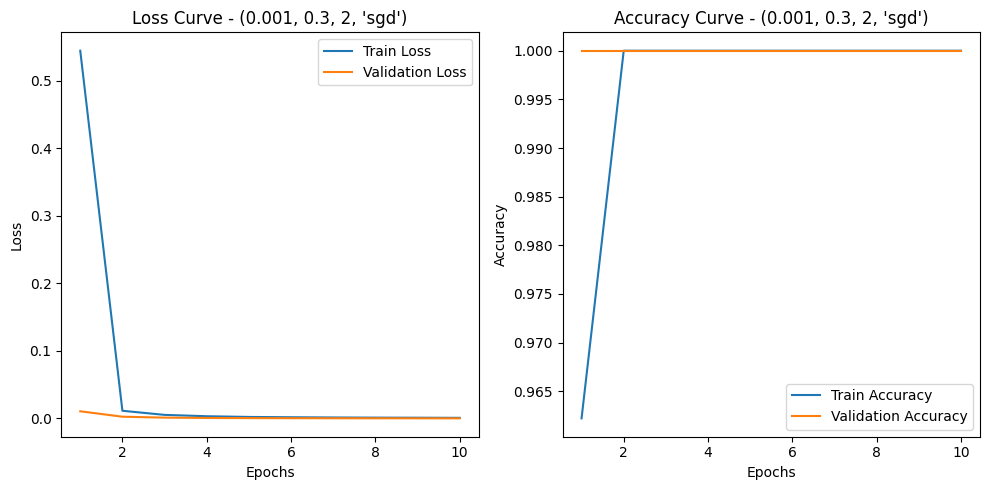

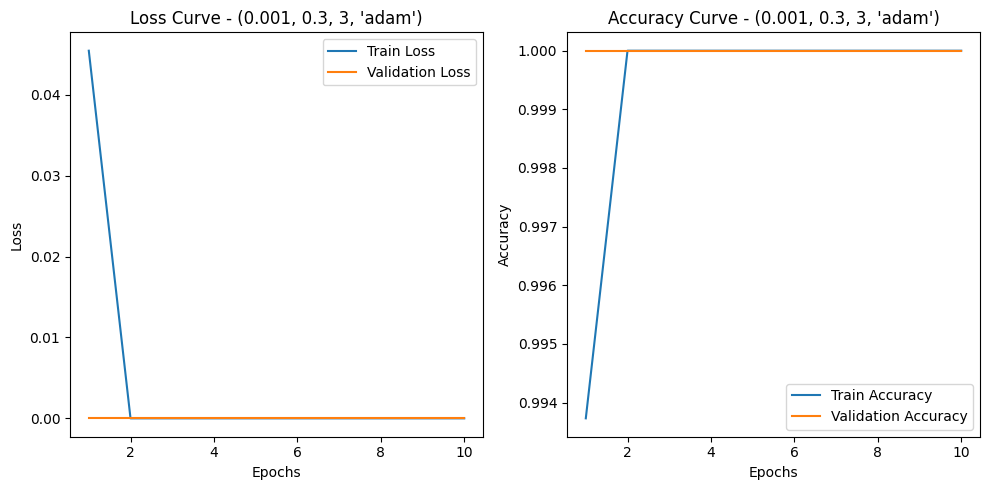

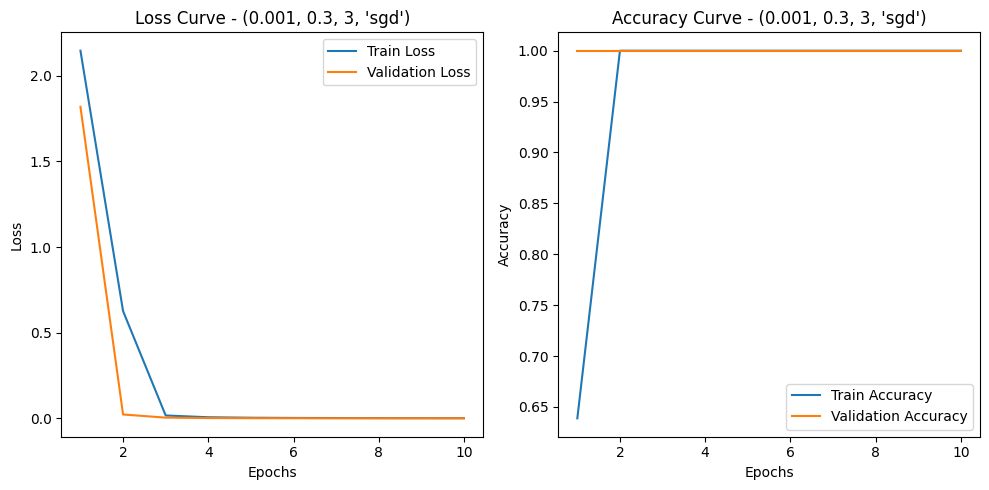

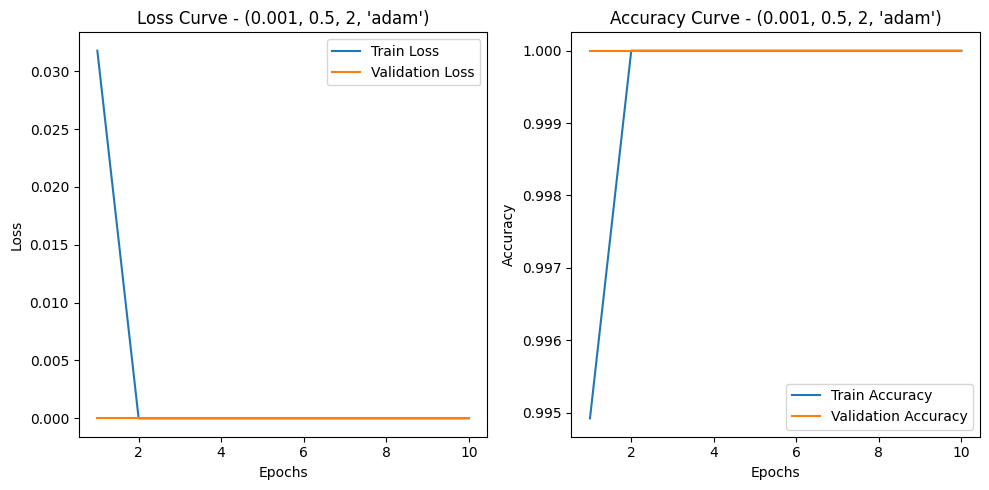

Training regression model 1/16 with LR: 0.001, Dropout: 0.3, Layers: 2, Optimizer: adam
Epoch 1/10, Train Loss: 0.0219, Val Loss: 0.0001
Epoch 2/10, Train Loss: 0.0127, Val Loss: 0.0000
Epoch 3/10, Train Loss: 0.0115, Val Loss: 0.0011
Epoch 4/10, Train Loss: 0.0101, Val Loss: 0.0000
Epoch 5/10, Train Loss: 0.0093, Val Loss: 0.0022
Epoch 6/10, Train Loss: 0.0081, Val Loss: 0.0005
Epoch 7/10, Train Loss: 0.0069, Val Loss: 0.0004
Epoch 8/10, Train Loss: 0.0059, Val Loss: 0.0012
Epoch 9/10, Train Loss: 0.0051, Val Loss: 0.0000
Epoch 10/10, Train Loss: 0.0042, Val Loss: 0.0001
Training regression model 2/16 with LR: 0.001, Dropout: 0.3, Layers: 2, Optimizer: sgd
Epoch 1/10, Train Loss: 0.0778, Val Loss: 0.0005
Epoch 2/10, Train Loss: 0.0156, Val Loss: 0.0004
Epoch 3/10, Train Loss: 0.0146, Val Loss: 0.0003
Epoch 4/10, Train Loss: 0.0135, Val Loss: 0.0003
Epoch 5/10, Train Loss: 0.0128, Val Loss: 0.0002
Epoch 6/10, Train Loss: 0.0122, Val Loss: 0.0003
Epoch 7/10, Train Loss: 0.0113, Val Loss

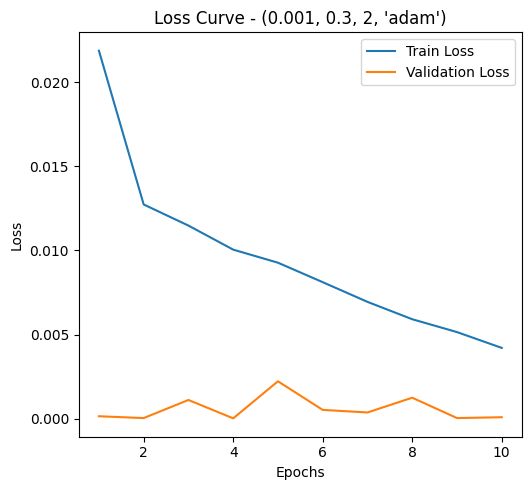

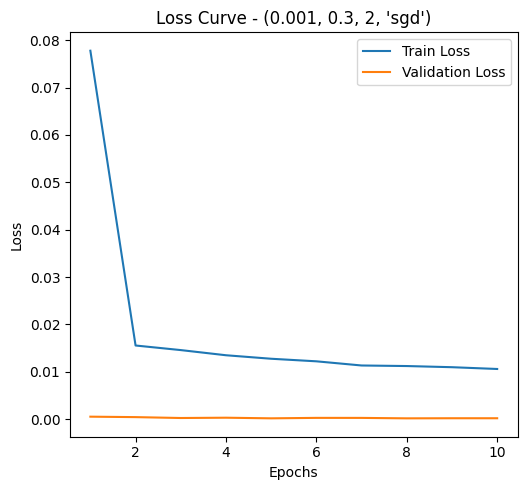

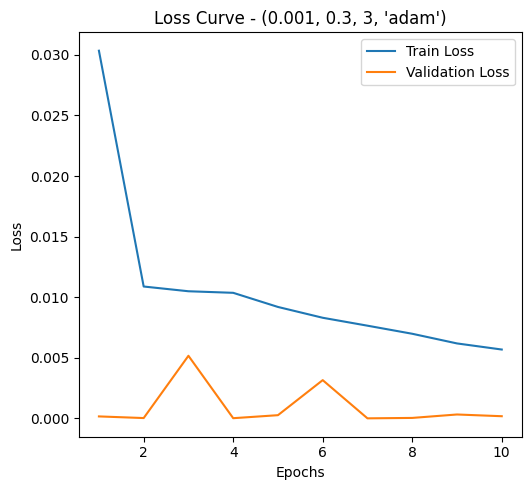

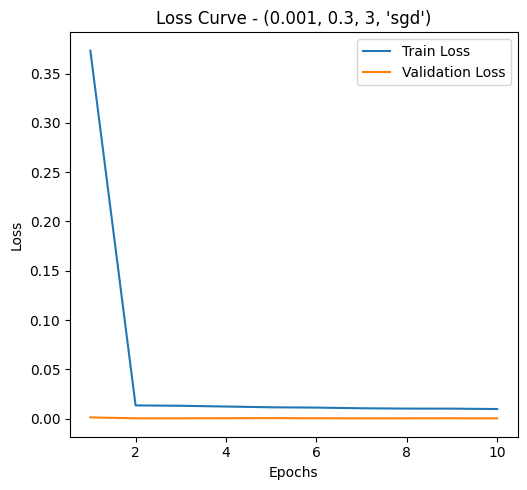

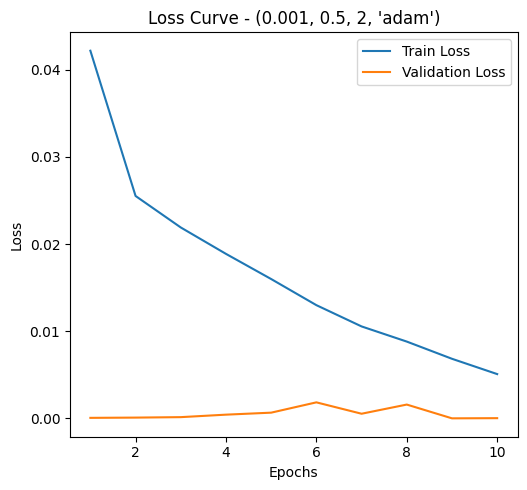

In [42]:
def get_optimizer(optimizer_name, model, learning_rate):
    if optimizer_name == 'adam':
        return torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'sgd':
        return torch.optim.SGD(model.parameters(), lr=learning_rate)

def evaluate_model(model, train_loader, val_loader, optimizer, num_epochs=10):
    model.to(device) 
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train() 
        running_loss = 0.0
        running_accuracy = 0.0
        total_train_samples = 0


        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            # forward pass
            outputs, _ = model(images)
            
            # loss calculation
            loss = model.calculate_loss(outputs, labels)
            
            # back pass
            loss.backward()
            optimizer.step()
            

            running_loss += loss.item()
            if model.task_type == 'classification':
                running_accuracy += model.calculate_accuracy(outputs, labels) * labels.size(0)
                total_train_samples += labels.size(0)

        # avg training loss and accuracy
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        if model.task_type == 'classification':
            avg_train_accuracy = running_accuracy / total_train_samples
            train_accuracies.append(avg_train_accuracy)
        
        # Validation step
        model.eval()
        val_loss = 0.0
        val_accuracy = 0.0
        total_val_samples = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs, _ = model(images) #fwd pass
                loss = model.calculate_loss(outputs, labels)
                val_loss += loss.item()

                if model.task_type == 'classification':
                    val_accuracy += model.calculate_accuracy(outputs, labels) * labels.size(0)
                    total_val_samples += labels.size(0)

        # Avg validation loss and accuracy
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        if model.task_type == 'classification':
            avg_val_accuracy = val_accuracy / total_val_samples
            val_accuracies.append(avg_val_accuracy)
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, '
                  f'Train Acc: {avg_train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, '
                  f'Val Acc: {avg_val_accuracy:.4f}')
        else:
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, '
                  f'Val Loss: {avg_val_loss:.4f}')
    
    return train_losses, val_losses, train_accuracies, val_accuracies

def plot_loss(history, combination, task_type='classification'):
    if task_type == 'classification':
        train_loss, val_loss, train_acc, val_acc = history[combination]
    else:
        train_loss, val_loss = history[combination]
    
    epochs = range(1, len(train_loss) + 1)
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'Loss Curve - {combination}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    if task_type == 'classification':
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_acc, label='Train Accuracy')
        plt.plot(epochs, val_acc, label='Validation Accuracy')
        plt.title(f'Accuracy Curve - {combination}')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

#hyperparameter grid
learning_rates = [0.001, 0.0001]
dropout_rates = [0.3, 0.5]
num_conv_layers = [2, 3]
optimizers = ['adam', 'sgd']


param_combinations = list(product(learning_rates, dropout_rates, num_conv_layers, optimizers))

history_classification = {}
best_model_info = {
    'combination': None,
    'val_accuracy': 0.0,
    'model_state': None
}

for i, (lr, dropout, num_layers, optimizer_choice) in enumerate(param_combinations):
    print(f"Training classification model {i+1}/{len(param_combinations)} with LR: {lr}, Dropout: {dropout}, Layers: {num_layers}, Optimizer: {optimizer_choice}")
    
    model = CNNModel(dropout_rate=dropout, num_conv_layers=num_layers, task_type='classification').to(device)
    optimizer = get_optimizer(optimizer_choice, model, lr)

    train_loss, val_loss, train_acc, val_acc = evaluate_model(model, train_loader, val_loader, optimizer, num_epochs=10)

    history_classification[(lr, dropout, num_layers, optimizer_choice)] = (train_loss, val_loss, train_acc, val_acc)


    if val_acc[-1] > best_model_info['val_accuracy']:
        best_model_info['val_accuracy'] = val_acc[-1]
        best_model_info['combination'] = (lr, dropout, num_layers, optimizer_choice)
        best_model_info['model_state'] = model.state_dict()  # store model's state


print("Best Model Configuration:")
print(f"Learning Rate: {best_model_info['combination'][0]}, Dropout: {best_model_info['combination'][1]}, "
      f"Layers: {best_model_info['combination'][2]}, Optimizer: {best_model_info['combination'][3]}")
print(f"Validation Accuracy: {best_model_info['val_accuracy']:.4f}")


for combination in param_combinations[:5]:  
    plot_loss(history_classification, combination)


history_regression = {}
best_reg_model_info = {
    'combination': None,
    'val_loss': float('inf'),  
    'model_state': None
}

for i, (lr, dropout, num_layers, optimizer_choice) in enumerate(param_combinations):
    print(f"Training regression model {i+1}/{len(param_combinations)} with LR: {lr}, Dropout: {dropout}, Layers: {num_layers}, Optimizer: {optimizer_choice}")
    
    model = CNNModel(dropout_rate=dropout, num_conv_layers=num_layers, task_type='regression').to(device)
    optimizer = get_optimizer(optimizer_choice, model, lr)

    train_loss, val_loss, _, _ = evaluate_model(model, train_loader, val_loader, optimizer, num_epochs=10)

    history_regression[(lr, dropout, num_layers, optimizer_choice)] = (train_loss, val_loss)


    if val_loss[-1] < best_reg_model_info['val_loss']:
        best_reg_model_info['val_loss'] = val_loss[-1]
        best_reg_model_info['combination'] = (lr, dropout, num_layers, optimizer_choice)
        best_reg_model_info['model_state'] = model.state_dict()  


print("Best Regression Model Configuration:")
print(f"Learning Rate: {best_reg_model_info['combination'][0]}, Dropout: {best_reg_model_info['combination'][1]}, "
      f"Layers: {best_reg_model_info['combination'][2]}, Optimizer: {best_reg_model_info['combination'][3]}")
print(f"Validation Loss: {best_reg_model_info['val_loss']:.4f}")


for combination in param_combinations[:5]:  
    plot_loss(history_regression, combination, task_type='regression')


### 2.4

Visualizing Feature Maps for Image 1
  Visualizing Feature Maps from Layer 1 - 32 filters


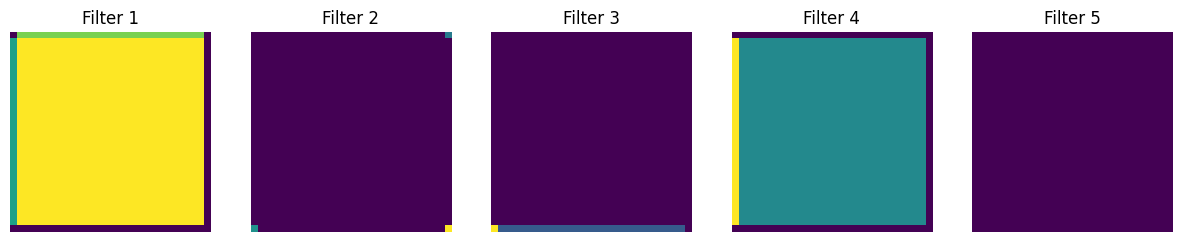

  Visualizing Feature Maps from Layer 2 - 64 filters


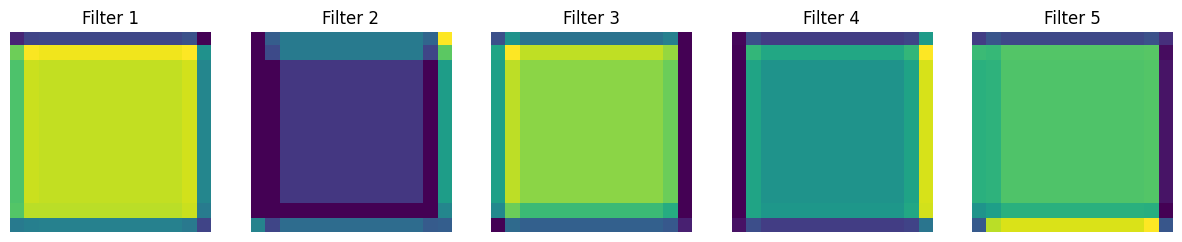

  Visualizing Feature Maps from Layer 3 - 64 filters


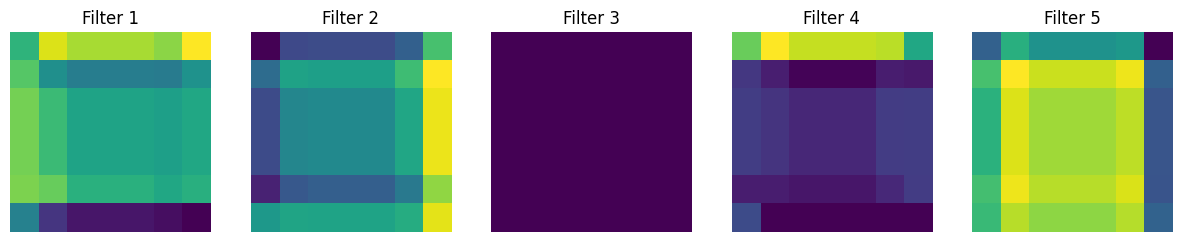

Visualizing Feature Maps for Image 2
  Visualizing Feature Maps from Layer 1 - 32 filters


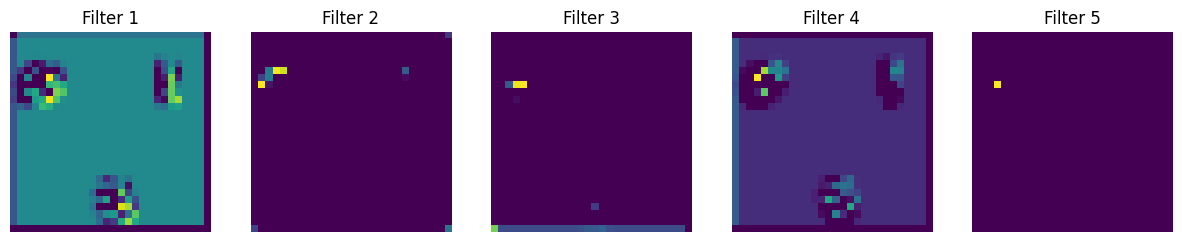

  Visualizing Feature Maps from Layer 2 - 64 filters


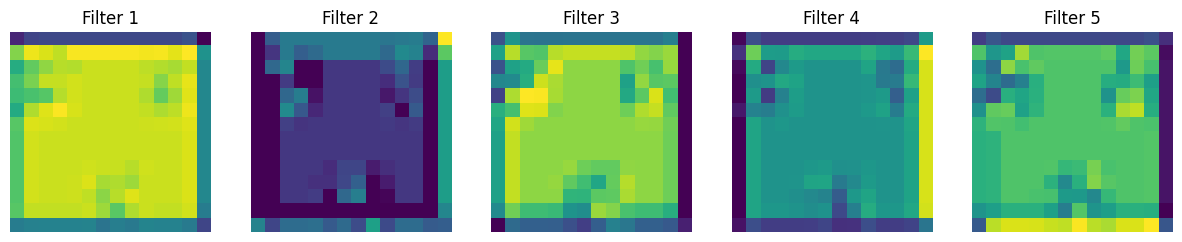

  Visualizing Feature Maps from Layer 3 - 64 filters


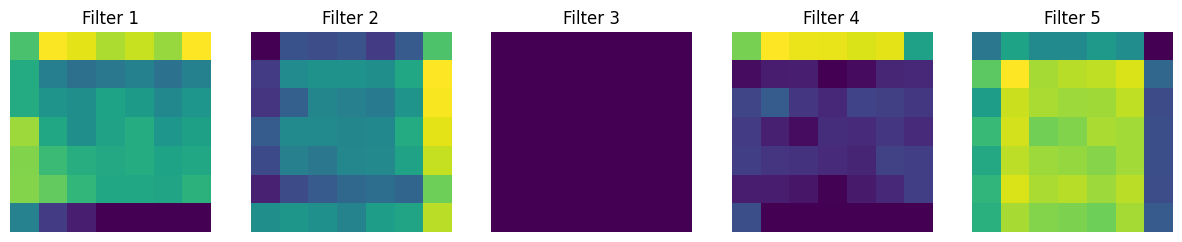

Visualizing Feature Maps for Image 3
  Visualizing Feature Maps from Layer 1 - 32 filters


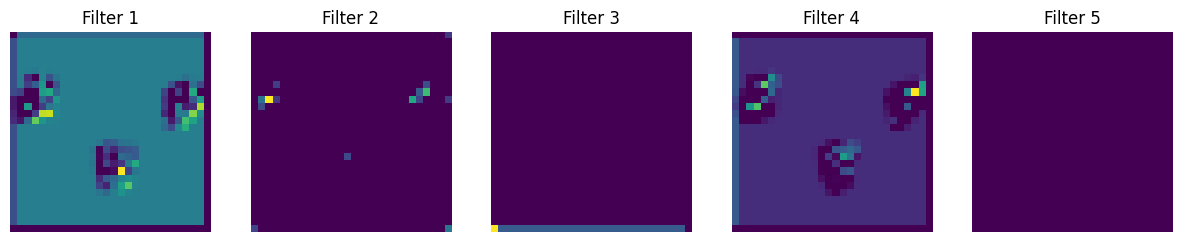

  Visualizing Feature Maps from Layer 2 - 64 filters


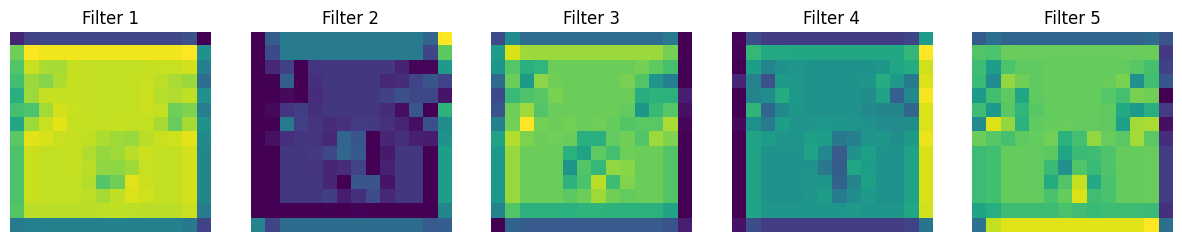

  Visualizing Feature Maps from Layer 3 - 64 filters


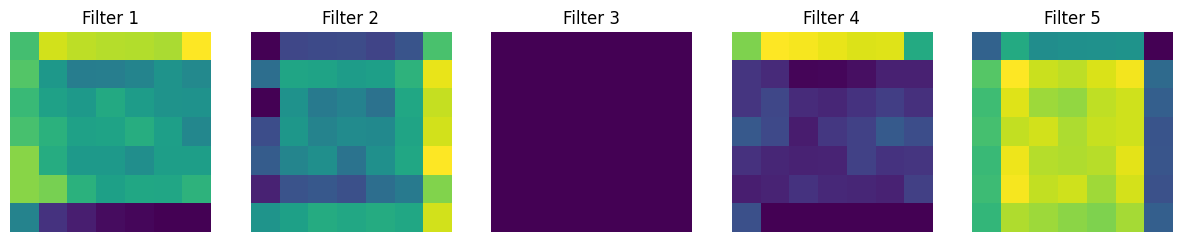

In [43]:
# def visualize_feature_maps(model, images):
#     model.eval()

#     with torch.no_grad():
#         _, feature_maps = model(images)

#     num_layers = len(feature_maps)
    
#     for i, feature_map in enumerate(feature_maps):
#         print(f"Visualizing Feature Maps from Layer {i+1}")
        
#         # Convert feature map to CPU and numpy array for visualization
#         feature_map = feature_map.cpu().numpy()

#         # Plot feature maps of the first image in the batch
#         num_filters = feature_map.shape[1]
        
#         fig, axes = plt.subplots(1, min(5, num_filters), figsize=(15, 5))  # Show first 5 feature maps
#         for idx in range(min(5, num_filters)):
#             axes[idx].imshow(feature_map[0, idx], cmap='gray')
#             axes[idx].set_title(f'Filter {idx+1}')
#         plt.show()


def visualize_feature_maps(model, images, max_filters=8):
    model.eval()

    with torch.no_grad():
        # fwd pass
        _, feature_maps = model(images)

    num_layers = len(feature_maps)
    num_images = images.size(0)

    for img_idx in range(num_images):
        print(f"Visualizing Feature Maps for Image {img_idx + 1}")
        
        for layer_idx, feature_map in enumerate(feature_maps):
            num_filters = feature_map.shape[1]
            print(f"  Visualizing Feature Maps from Layer {layer_idx + 1} - {num_filters} filters")

            filters_to_display = min(max_filters, num_filters)

            fig, axes = plt.subplots(1, filters_to_display, figsize=(filters_to_display * 3, 3))

            for filter_idx in range(filters_to_display):
                filter_feature_map = feature_map[img_idx, filter_idx].cpu().detach().numpy()

                axes[filter_idx].imshow(filter_feature_map, cmap='viridis')
                axes[filter_idx].axis('off')
                axes[filter_idx].set_title(f'Filter {filter_idx + 1}')
            
            plt.show()

images, _ = next(iter(train_loader))  #batch of images
images = images[:3].to(device)  # selcting first 3 images
visualize_feature_maps(model, images, max_filters=5)



After analysing the feature maps, we can say that the first layer is sort of trying to learn the various edges and features that make up the handwritten digits whereas the second layer is trying to learn the position and number of digits present - segmenting each digit.

## Question 3:

### 3.1

In [52]:
def load_mnist_data(data_dir):
    def get_images_and_labels(split):
        images = []
        labels = []
        split_dir = os.path.join(data_dir, split)
        
        for folder in os.listdir(split_dir):
            folder_path = os.path.join(split_dir, folder)
            if os.path.isdir(folder_path):
                # Use the folder name as the label (ensure it's an integer)
                label = int(folder)  # Assuming folder names are digits (0-9)
                
                for img_name in os.listdir(folder_path):
                    img_path = os.path.join(folder_path, img_name)
                    img = Image.open(img_path).convert('L')  
                    images.append(img)
                    labels.append(label)
        return images, labels

    train_images, train_labels = get_images_and_labels('train')
    val_images, val_labels = get_images_and_labels('val')
    test_images, test_labels = get_images_and_labels('test')
    
    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)


def multi_label_one_hot_encode(labels, max_digits=3, num_classes=10):
    one_hot_labels = torch.zeros(len(labels), num_classes)  # tensor for one-hot encoding
    
    for i, label in enumerate(labels):
        padded_label = str(label).zfill(max_digits)
        
        for digit in padded_label:
            if digit.isdigit():
                one_hot_labels[i][int(digit)] = 1.0
            else:
                # print(f"Warning: Skipping non-numeric character '{digit}' in label '{label}'")
                continue
    
    return one_hot_labels


### 3.2

the `MultiLabelCNN` does `not require an additional activation function` after the last linear layer. The use of `BCEWithLogitsLoss` provides both the activation function (sigmoid) and the loss calculation in one step, which simplifies the model architecture and enhances stability during training.

By not including an activation function after the last layer, we allow the model to output unbounded logits. This approach is more numerically stable and allows the loss function to work with the full range of possible outputs, which can lead to better training dynamics.

A CNN classifier for multi-class classification would often use a softmax activation after the last layer and CrossEntropyLoss, as it deals with mutually exclusive classes. Whereas this multi-label approach allows for non-mutually exclusive class predictions, which is more appropriate for scenarios where an instance can belong to multiple categories simultaneously.

In [53]:
class MultiLabelCNN(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.5, num_conv_layers=2):
        super(MultiLabelCNN, self).__init__()

        self.conv_layers = nn.ModuleList()
        
        # initial Conv Layer
        self.conv_layers.append(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1))
        
        # additional Conv Layers
        for i in range(1, num_conv_layers):
            in_channels = 32 if i == 1 else 64
            self.conv_layers.append(nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=1, padding=1))
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=dropout_rate)

        dummy_input = torch.randn(1, 1, 28, 28)
        conv_out_size = self._get_conv_output(dummy_input)

        self.fc1 = nn.Linear(conv_out_size, 128)
        self.fc2 = nn.Linear(128, num_classes)  # o/p layer for multi-label classification

        # loss function
        self.loss_function = nn.BCEWithLogitsLoss()

    def _get_conv_output(self, x):
        for conv in self.conv_layers:
            x = self.pool(F.relu(conv(x)))
        return x.numel()

    def forward(self, x):
        feature_maps = []  # intermediate feature maps
        
        # pass through each convolutional layer
        for conv in self.conv_layers:
            x = F.relu(conv(x))
            feature_maps.append(x) 
            x = self.pool(x) 
            
        # Flatten the output
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        logits = self.fc2(x) #no activation
        return logits, feature_maps

    def calculate_loss(self, outputs, labels): #binary cross entropy loss
        loss = self.loss_function(outputs, labels.float())
        return loss

    def calculate_accuracy(self, outputs, labels, threshold=0.5):
        probabilities = torch.sigmoid(outputs) #sigmod for probabilities
        predicted = (probabilities > threshold).float()  # binarize predictions

        correct = (predicted == labels).sum().item()  # count correct predictions
        total = labels.numel()  # total labels
        accuracy = correct / total
        return accuracy


In [54]:
def train_model(model, train_loader, val_loader, optimizer, num_epochs=10, device='cpu'):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_accuracy = 0.0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # gradients = zero
            
            # fwd pass
            outputs, _ = model(images)
            
            loss = F.binary_cross_entropy_with_logits(outputs, labels.float())
            
            # back pass
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            running_accuracy += model.calculate_accuracy(outputs, labels) * labels.size(0)
            total += labels.size(0)

        avg_train_loss = running_loss / len(train_loader)

        # avg accuracy
        avg_train_accuracy = running_accuracy / total

    
        model.eval()
        val_loss = 0.0
        val_accuracy = 0.0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                # fwd pass
                outputs, _ = model(images)
                loss = F.binary_cross_entropy_with_logits(outputs, labels.float())
                val_loss += loss.item()

                # accuracy
                val_accuracy += model.calculate_accuracy(outputs, labels) * labels.size(0)
                total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        avg_val_accuracy = val_accuracy / total

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_accuracy:.4f}')


class DoubleMNISTDataset(Dataset):
    def __init__(self, images, labels, task_type='classification', transform=None):
        self.images = images
        self.labels = labels  
        self.transform = transform
        self.task_type = task_type  

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx] 

        if self.transform:
            image = self.transform(image)

        if self.task_type == 'classification':
            label = torch.tensor(label, dtype=torch.float)

        elif self.task_type == 'regression':
            label = torch.tensor(float(label), dtype=torch.float)

        return image, label



In [55]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


data_dir = '../../data/external/double_mnist'
(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = load_mnist_data(data_dir)

train_labels_tensor = torch.tensor(train_labels)
val_labels_tensor = torch.tensor(val_labels)
test_labels_tensor = torch.tensor(test_labels)

train_labels_one_hot = multi_label_one_hot_encode(train_labels_tensor, max_digits=3)
val_labels_one_hot = multi_label_one_hot_encode(val_labels_tensor, max_digits=3)
test_labels_one_hot = multi_label_one_hot_encode(test_labels_tensor, max_digits=3)

train_dataset = DoubleMNISTDataset(train_images, train_labels_one_hot, task_type='classification', transform=transform)
val_dataset = DoubleMNISTDataset(val_images, val_labels_one_hot, task_type='classification', transform=transform)
test_dataset = DoubleMNISTDataset(test_images, test_labels_one_hot, task_type='classification', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = MultiLabelCNN(num_classes=10).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

num_epochs = 10
# for epoch in range(num_epochs):
    # print(f'Epoch {epoch + 1}/{num_epochs}')
train_model(model, train_loader, val_loader, optimizer, num_epochs=10, device=device)

/var/folders/20/18w4gmzj0cx3gb5rcp0c04tr0000gn/T/ipykernel_5852/412717764.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float)


Epoch 1/10, Train Loss: 0.4837, Train Acc: 0.8149, Val Loss: 0.4668, Val Acc: 0.8165
Epoch 2/10, Train Loss: 0.4661, Train Acc: 0.8176, Val Loss: 0.4650, Val Acc: 0.8165
Epoch 3/10, Train Loss: 0.4570, Train Acc: 0.8183, Val Loss: 0.4667, Val Acc: 0.8165
Epoch 4/10, Train Loss: 0.4492, Train Acc: 0.8194, Val Loss: 0.4747, Val Acc: 0.8198
Epoch 5/10, Train Loss: 0.4426, Train Acc: 0.8202, Val Loss: 0.4845, Val Acc: 0.8187
Epoch 6/10, Train Loss: 0.4346, Train Acc: 0.8208, Val Loss: 0.4782, Val Acc: 0.8194
Epoch 7/10, Train Loss: 0.4252, Train Acc: 0.8217, Val Loss: 0.4747, Val Acc: 0.8217
Epoch 8/10, Train Loss: 0.4128, Train Acc: 0.8230, Val Loss: 0.4735, Val Acc: 0.8226
Epoch 9/10, Train Loss: 0.3981, Train Acc: 0.8257, Val Loss: 0.4449, Val Acc: 0.8252
Epoch 10/10, Train Loss: 0.3836, Train Acc: 0.8305, Val Loss: 0.4494, Val Acc: 0.8269


### 3.3

In [ ]:
# def train_model(model, train_loader, val_loader, optimizer, num_epochs=10, device='cpu'):
#     model.to(device)
#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0
#         running_accuracy = 0.0
#         total = 0

#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)

#             optimizer.zero_grad() 
            
#             # fwd pass
#             outputs, _ = model(images)  
            

#             loss = F.binary_cross_entropy_with_logits(outputs, labels.float()) 
            
#             # back pass
#             loss.backward()
#             optimizer.step()
            
#             running_loss += loss.item()

#             running_accuracy += model.calculate_accuracy(outputs, labels) * labels.size(0)
#             total += labels.size(0)

#         avg_train_loss = running_loss / len(train_loader)

#         # avg accuracy
#         avg_train_accuracy = running_accuracy / total

#         # validation phase
#         model.eval()
#         val_loss = 0.0
#         val_accuracy = 0.0
#         total = 0

#         with torch.no_grad():
#             for images, labels in val_loader:
#                 images, labels = images.to(device), labels.to(device)

#                 # fwd pass
#                 outputs, _ = model(images)
#                 loss = F.binary_cross_entropy_with_logits(outputs, labels.float())
#                 val_loss += loss.item()

#                 # acc. calculation
#                 val_accuracy += model.calculate_accuracy(outputs, labels) * labels.size(0)
#                 total += labels.size(0)

#         avg_val_loss = val_loss / len(val_loader)
#         avg_val_accuracy = val_accuracy / total

#         print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_accuracy:.4f}')
#     return avg_train_loss, avg_val_loss 


# hyperparameter_grid = {
#     'learning_rate': [0.001, 0.01],
#     'num_epochs': [10],
#     'dropout_rate': [0.3, 0.5],
#     'num_conv_layers': [2],
#     'optimizer': ['Adam', 'SGD']
# }

# hyperparameter_combinations = list(itertools.product(
#     hyperparameter_grid['learning_rate'],
#     hyperparameter_grid['num_epochs'],
#     hyperparameter_grid['dropout_rate'],
#     hyperparameter_grid['num_conv_layers'],
#     hyperparameter_grid['optimizer']
# ))
    
# def train_model_with_params(params, train_loader, val_loader, device):
#     learning_rate, num_epochs, dropout_rate, num_conv_layers, optimizer_name = params
    
#     model = MultiLabelCNN(num_classes=10, dropout_rate=dropout_rate, num_conv_layers=num_conv_layers).to(device)


#     optimizer = optim.Adam(model.parameters(), lr=learning_rate) if optimizer_name == 'Adam' else optim.SGD(model.parameters(), lr=learning_rate)

#     train_losses = []
#     val_losses = []

#     # for epoch in range(num_epochs):
#     avg_train_loss, avg_val_loss = train_model(model, train_loader, val_loader, optimizer, num_epochs=10, device=device)
#     train_losses.append(avg_train_loss)
#     val_losses.append(avg_val_loss)

#     return train_losses, val_losses

# results_history = {}
# for params in hyperparameter_combinations:
#     learning_rate, num_epoch, dropout_rate, num_conv_layer, optimizer = params
#     print(f"=======================================================\n")
#     # print(f"Training with params: {params}")
#     print(f"Training with: Learning Rate = {learning_rate}, Epochs = {num_epoch}, Dropout Rate = {dropout_rate}, Conv Layers = {num_conv_layer}, Optimizer = '{optimizer}'")
    
#     train_losses, val_losses = train_model_with_params(params, train_loader, val_loader, device)
    
#     results_history[params] = (train_losses, val_losses)


Training with: Learning Rate = 0.001, Epochs = 10, Dropout Rate = 0.3, Conv Layers = 2, Optimizer = 'Adam'


/var/folders/20/18w4gmzj0cx3gb5rcp0c04tr0000gn/T/ipykernel_5852/412717764.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float)


Epoch 1/10, Train Loss: 0.4787, Train Acc: 0.8164, Val Loss: 0.4643, Val Acc: 0.8165
Epoch 2/10, Train Loss: 0.4612, Train Acc: 0.8177, Val Loss: 0.4679, Val Acc: 0.8165
Epoch 3/10, Train Loss: 0.4501, Train Acc: 0.8193, Val Loss: 0.4719, Val Acc: 0.8197
Epoch 4/10, Train Loss: 0.4414, Train Acc: 0.8204, Val Loss: 0.4765, Val Acc: 0.8196
Epoch 5/10, Train Loss: 0.4289, Train Acc: 0.8212, Val Loss: 0.4679, Val Acc: 0.8199
Epoch 6/10, Train Loss: 0.4152, Train Acc: 0.8223, Val Loss: 0.4722, Val Acc: 0.8216
Epoch 7/10, Train Loss: 0.4014, Train Acc: 0.8253, Val Loss: 0.4617, Val Acc: 0.8245
Epoch 8/10, Train Loss: 0.3868, Train Acc: 0.8290, Val Loss: 0.4463, Val Acc: 0.8251
Epoch 9/10, Train Loss: 0.3758, Train Acc: 0.8317, Val Loss: 0.4389, Val Acc: 0.8298
Epoch 10/10, Train Loss: 0.3596, Train Acc: 0.8375, Val Loss: 0.4328, Val Acc: 0.8319

Training with: Learning Rate = 0.001, Epochs = 10, Dropout Rate = 0.3, Conv Layers = 2, Optimizer = 'SGD'
Epoch 1/10, Train Loss: 0.6674, Train Acc:

Training with: Learning Rate = 0.001, Epochs = 10, Dropout Rate = 0.3, Conv Layers = 2, Optimizer = 'Adam'


/var/folders/20/18w4gmzj0cx3gb5rcp0c04tr0000gn/T/ipykernel_5852/412717764.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float)


Epoch 1/10, Train Loss: 0.4827, Train Acc: 0.8145, Val Loss: 0.4714, Val Acc: 0.8165
Epoch 2/10, Train Loss: 0.4640, Train Acc: 0.8176, Val Loss: 0.4670, Val Acc: 0.8165
Epoch 3/10, Train Loss: 0.4542, Train Acc: 0.8183, Val Loss: 0.4746, Val Acc: 0.8198
Epoch 4/10, Train Loss: 0.4443, Train Acc: 0.8197, Val Loss: 0.4771, Val Acc: 0.8184
Epoch 5/10, Train Loss: 0.4331, Train Acc: 0.8209, Val Loss: 0.4504, Val Acc: 0.8212
Epoch 6/10, Train Loss: 0.4133, Train Acc: 0.8252, Val Loss: 0.4434, Val Acc: 0.8250
Epoch 7/10, Train Loss: 0.3959, Train Acc: 0.8287, Val Loss: 0.4423, Val Acc: 0.8269
Epoch 8/10, Train Loss: 0.3821, Train Acc: 0.8325, Val Loss: 0.4297, Val Acc: 0.8290
Epoch 9/10, Train Loss: 0.3706, Train Acc: 0.8359, Val Loss: 0.4361, Val Acc: 0.8274
Epoch 10/10, Train Loss: 0.3609, Train Acc: 0.8385, Val Loss: 0.4402, Val Acc: 0.8311
Training with: Learning Rate = 0.001, Epochs = 10, Dropout Rate = 0.3, Conv Layers = 2, Optimizer = 'SGD'
Epoch 1/10, Train Loss: 0.6465, Train Acc: 

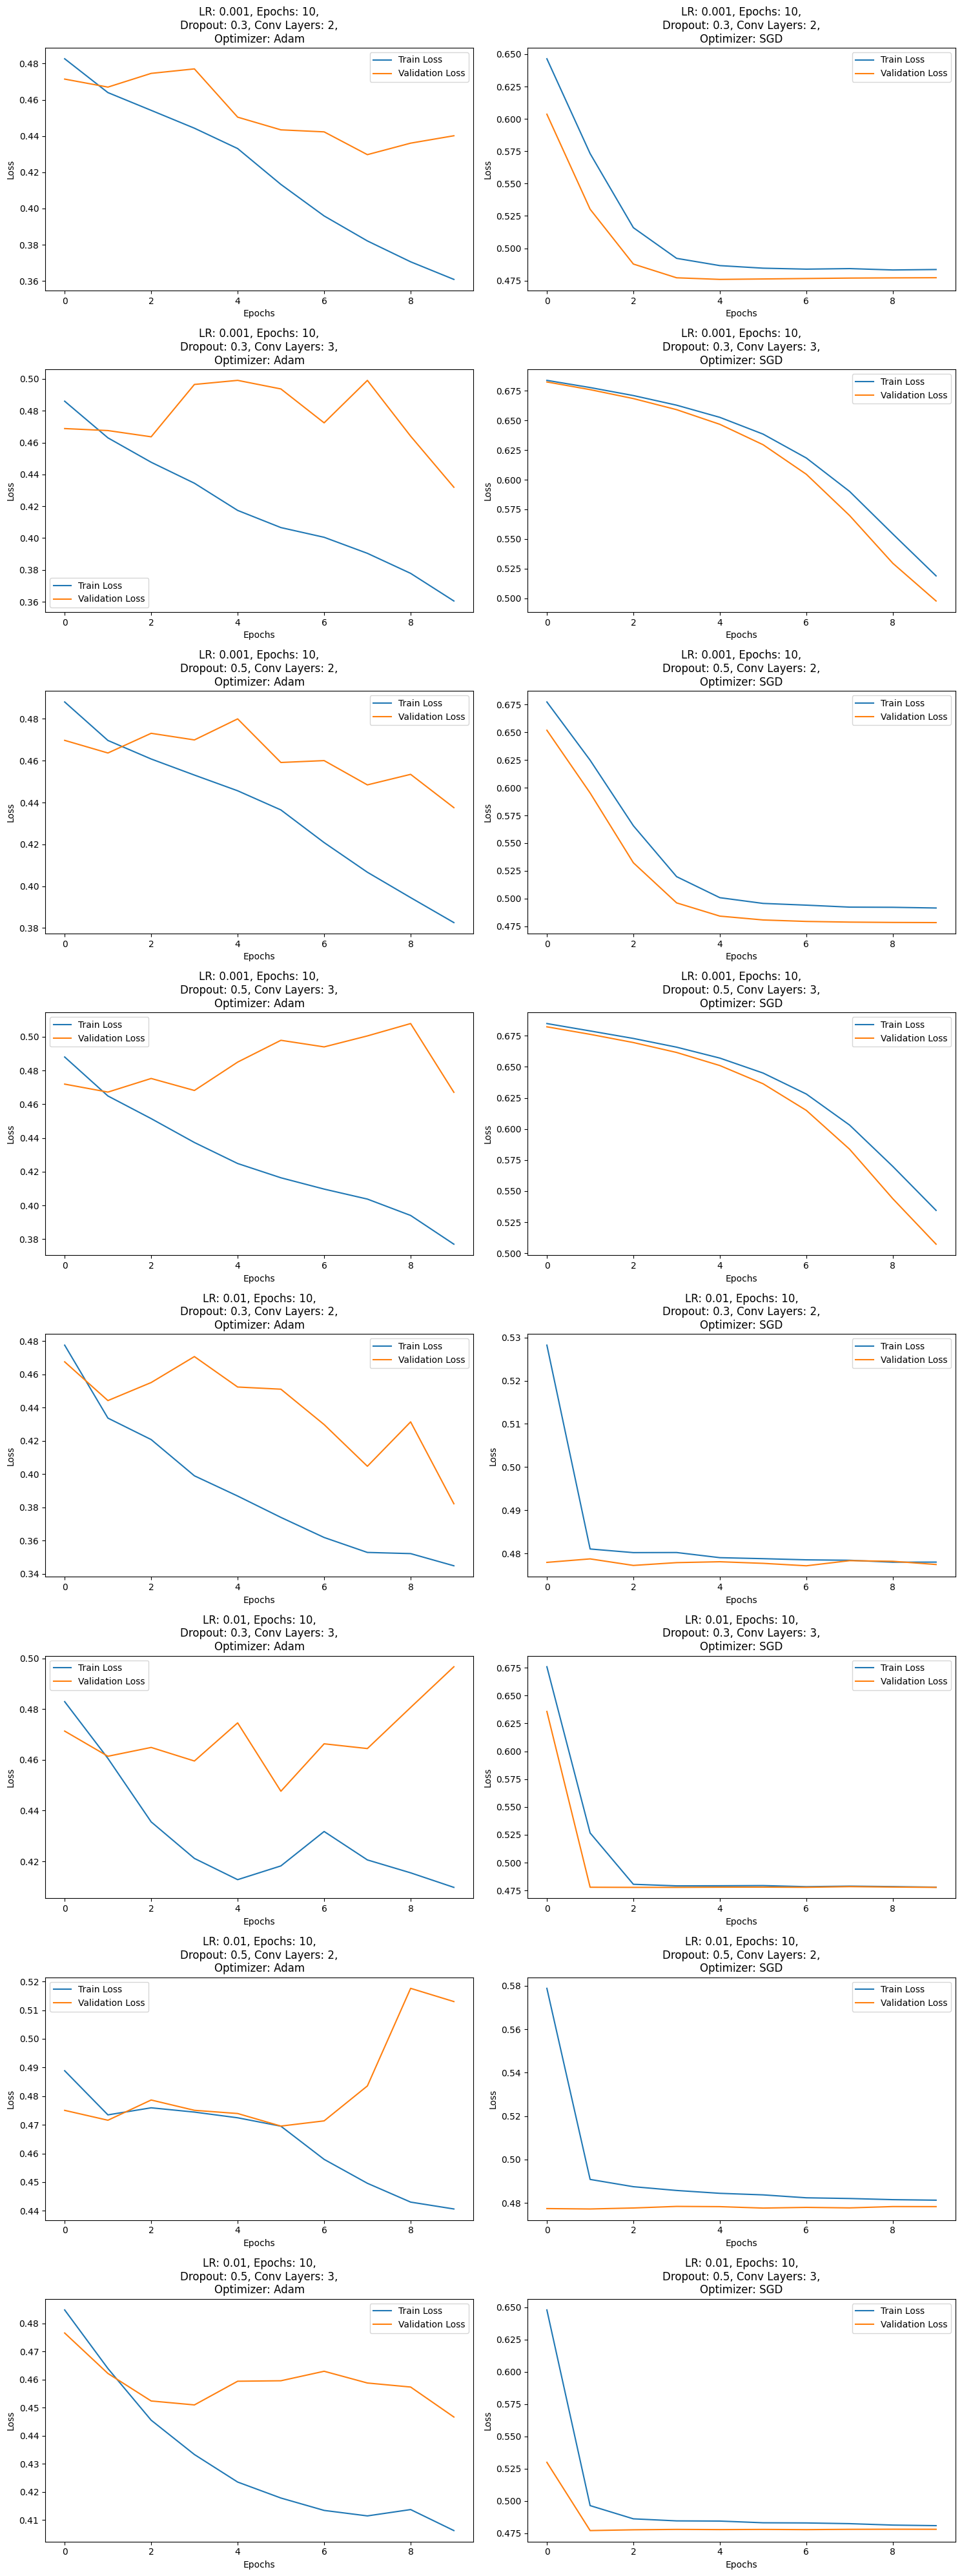


Best Model Parameters: (0.01, 10, 0.3, 2, 'Adam')
Best Validation Accuracy: 0.8465


/var/folders/20/18w4gmzj0cx3gb5rcp0c04tr0000gn/T/ipykernel_5852/412717764.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float)
/var/folders/20/18w4gmzj0cx3gb5rcp0c04tr0000gn/T/ipykernel_5852/412717764.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float)



Best Model Performance:
Train - Exact Match Accuracy: 0.1390, Hamming Accuracy: 0.8602
Validation - Exact Match Accuracy: 0.1470, Hamming Accuracy: 0.8465
Test - Exact Match Accuracy: 0.0598, Hamming Accuracy: 0.8408


In [ ]:
from sklearn.metrics import hamming_loss

def train_model(model, train_loader, val_loader, optimizer, num_epochs=10, device='mps'):
    model.to(device)
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_accuracy = 0.0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs, _ = model(images)
            loss = F.binary_cross_entropy_with_logits(outputs, labels.float())
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            running_accuracy += model.calculate_accuracy(outputs, labels) * labels.size(0)
            total += labels.size(0)

        avg_train_loss = running_loss / len(train_loader)
        avg_train_accuracy = running_accuracy / total
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_accuracy)

        model.eval()
        val_loss = 0.0
        val_accuracy = 0.0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs, _ = model(images)
                loss = F.binary_cross_entropy_with_logits(outputs, labels.float())
                val_loss += loss.item()
                val_accuracy += model.calculate_accuracy(outputs, labels) * labels.size(0)
                total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        avg_val_accuracy = val_accuracy / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_accuracy:.4f}')
    
    return train_losses, val_losses, train_accuracies, val_accuracies

def evaluate_model(model, data_loader, device):
    model.eval()
    exact_match = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs, _ = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            exact_match += torch.all(preds == labels, dim=1).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    exact_match_accuracy = exact_match / total
    hamming_accuracy = 1 - hamming_loss(all_labels, all_preds)
    
    return exact_match_accuracy, hamming_accuracy

hyperparameter_grid = {
    'learning_rate': [0.001, 0.01],
    'num_epochs': [10],
    'dropout_rate': [0.3, 0.5],
    'num_conv_layers': [2, 3],
    'optimizer': ['Adam', 'SGD']
}

hyperparameter_combinations = list(itertools.product(
    hyperparameter_grid['learning_rate'],
    hyperparameter_grid['num_epochs'],
    hyperparameter_grid['dropout_rate'],
    hyperparameter_grid['num_conv_layers'],
    hyperparameter_grid['optimizer']
))

def train_model_with_params(params, train_loader, val_loader, device):
    learning_rate, num_epochs, dropout_rate, num_conv_layers, optimizer_name = params
    
    model = MultiLabelCNN(num_classes=10, dropout_rate=dropout_rate, num_conv_layers=num_conv_layers).to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate) if optimizer_name == 'Adam' else optim.SGD(model.parameters(), lr=learning_rate)

    train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, optimizer, num_epochs=num_epochs, device=device)

    return model, train_losses, val_losses, train_accuracies, val_accuracies

results_history = {}
best_val_accuracy = 0
best_model = None
best_params = None

for params in hyperparameter_combinations:
    learning_rate, num_epochs, dropout_rate, num_conv_layers, optimizer = params
    print(f"=======================================================")
    print(f"Training with: Learning Rate = {learning_rate}, Epochs = {num_epochs}, Dropout Rate = {dropout_rate}, Conv Layers = {num_conv_layers}, Optimizer = '{optimizer}'")
    
    model, train_losses, val_losses, train_accuracies, val_accuracies = train_model_with_params(params, train_loader, val_loader, device)
    
    results_history[params] = (train_losses, val_losses, train_accuracies, val_accuracies)
    
    if val_accuracies[-1] > best_val_accuracy:
        best_val_accuracy = val_accuracies[-1]
        best_model = model
        best_params = params

num_combinations = len(results_history)
rows = (num_combinations + 1) // 2  
cols = 2  

plt.figure(figsize=(15, 5 * rows))  

for i, (params, (train_losses, val_losses, _, _)) in enumerate(results_history.items()):
    plt.subplot(rows, cols, i+1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f"LR: {params[0]}, Epochs: {params[1]},\nDropout: {params[2]}, Conv Layers: {params[3]},\nOptimizer: {params[4]}")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plt.tight_layout()
plt.show()

print("\nBest Model Parameters:", best_params)
print("Best Validation Accuracy:", best_val_accuracy)

train_exact, train_hamming = evaluate_model(best_model, train_loader, device)
val_exact, val_hamming = evaluate_model(best_model, val_loader, device)
test_exact, test_hamming = evaluate_model(best_model, test_loader, device)

print("\nBest Model Performance:")
print(f"Train - Exact Match Accuracy: {train_exact:.4f}, Hamming Accuracy: {train_hamming:.4f}")
print(f"Validation - Exact Match Accuracy: {val_exact:.4f}, Hamming Accuracy: {val_hamming:.4f}")
print(f"Test - Exact Match Accuracy: {test_exact:.4f}, Hamming Accuracy: {test_hamming:.4f}")

## Question 4

### 4.1

In [ ]:
class FashionMNISTDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.labels = torch.tensor(data.iloc[:, 0].values)
        self.pixels = torch.tensor(data.iloc[:, 1:].values / 255.0, dtype=torch.float32)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = self.pixels[idx].reshape(1, 28, 28)  # Reshape to (1, 28, 28) for CNN
        label = self.labels[idx]
        return image, label

# 2. Define the CNN Autoencoder with Classifier
class CNNAutoencoderClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNAutoencoderClassifier, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        classified = self.classifier(encoded)
        return decoded, classified
    
def train_model(model, train_loader, test_loader, num_epochs, device):
    criterion_recon = nn.MSELoss()
    criterion_class = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0
        
        # Training phase
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            reconstructed, classified = model(images)
            
            loss_recon = criterion_recon(reconstructed, images)
            loss_class = criterion_class(classified, labels)
            loss = loss_recon + loss_class
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Calculate training accuracy
            _, predicted = torch.max(classified.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * train_correct / train_total
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation phase
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                reconstructed, classified = model(images)
                
                loss_recon = criterion_recon(reconstructed, images)
                loss_class = criterion_class(classified, labels)
                loss = loss_recon + loss_class
                
                test_loss += loss.item()
                
                _, predicted = torch.max(classified.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
                
        test_loss = test_loss / len(test_loader)
        test_accuracy = 100 * test_correct / test_total
        
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')
    
    return train_losses, test_losses

Epoch [1/10], Train Loss: 0.6131, Train Acc: 78.41%, Test Loss: 0.3661, Test Acc: 87.19%
Epoch [2/10], Train Loss: 0.3714, Train Acc: 87.14%, Test Loss: 0.2910, Test Acc: 89.32%
Epoch [3/10], Train Loss: 0.3149, Train Acc: 89.11%, Test Loss: 0.2763, Test Acc: 90.09%
Epoch [4/10], Train Loss: 0.2785, Train Acc: 90.39%, Test Loss: 0.2490, Test Acc: 90.88%
Epoch [5/10], Train Loss: 0.2534, Train Acc: 91.10%, Test Loss: 0.2374, Test Acc: 91.34%
Epoch [6/10], Train Loss: 0.2319, Train Acc: 92.13%, Test Loss: 0.2299, Test Acc: 91.77%
Epoch [7/10], Train Loss: 0.2153, Train Acc: 92.54%, Test Loss: 0.2367, Test Acc: 91.69%
Epoch [8/10], Train Loss: 0.1979, Train Acc: 93.14%, Test Loss: 0.2212, Test Acc: 92.14%
Epoch [9/10], Train Loss: 0.1838, Train Acc: 93.56%, Test Loss: 0.2253, Test Acc: 92.27%
Epoch [10/10], Train Loss: 0.1707, Train Acc: 94.05%, Test Loss: 0.2491, Test Acc: 91.68%


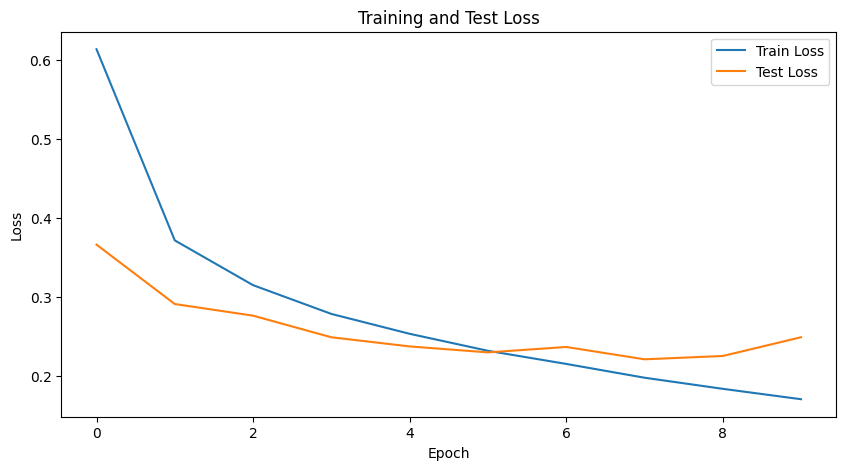

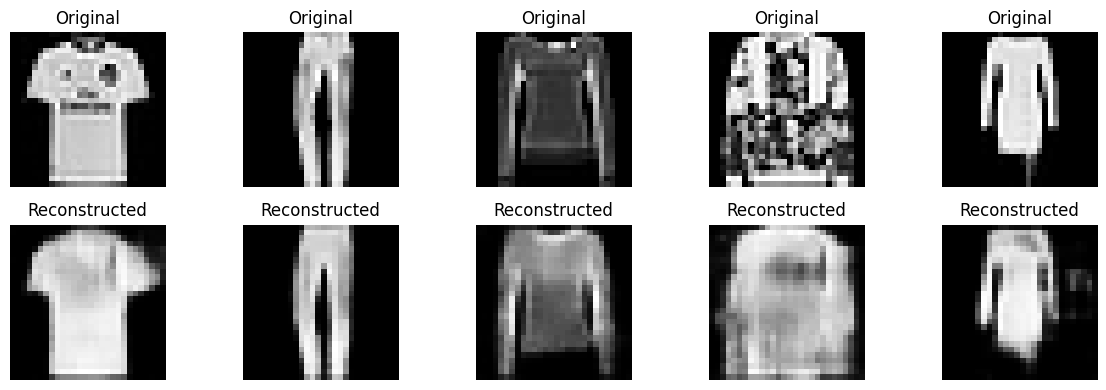

In [ ]:
train_data = pd.read_csv('../../data/external/fashion/fashion-mnist_train.csv')
test_data = pd.read_csv('../../data/external/fashion/fashion-mnist_test.csv')
train_dataset = FashionMNISTDataset(train_data)
test_dataset = FashionMNISTDataset(test_data)

# data loders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


model = CNNAutoencoderClassifier().to(device)

num_epochs = 10
train_losses, test_losses = train_model(model, train_loader, test_loader, num_epochs, device)


plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

def visualize_reconstructions(model, test_loader, num_images=5):
    model.eval()
    with torch.no_grad():
        images, labels = next(iter(test_loader))
        images = images[:num_images].to(device)
        reconstructed, _ = model(images)

        # original and reconstructed images
        fig, axes = plt.subplots(2, num_images, figsize=(12, 4))
        for i in range(num_images):
            axes[0, i].imshow(images[i].cpu().squeeze(), cmap='gray')
            axes[0, i].axis('off')
            axes[0, i].set_title('Original')

            axes[1, i].imshow(reconstructed[i].cpu().squeeze(), cmap='gray')
            axes[1, i].axis('off')
            axes[1, i].set_title('Reconstructed')
            
        plt.tight_layout()
        plt.show()

visualize_reconstructions(model, test_loader)

# evaluate final model
model.eval()
all_predictions = []
all_labels = []

### 4.2

### 4.2.1

Dataset splits:
Training set: 42000 samples
Validation set: 6000 samples
Test set: 12000 samples

Visualization of training samples:


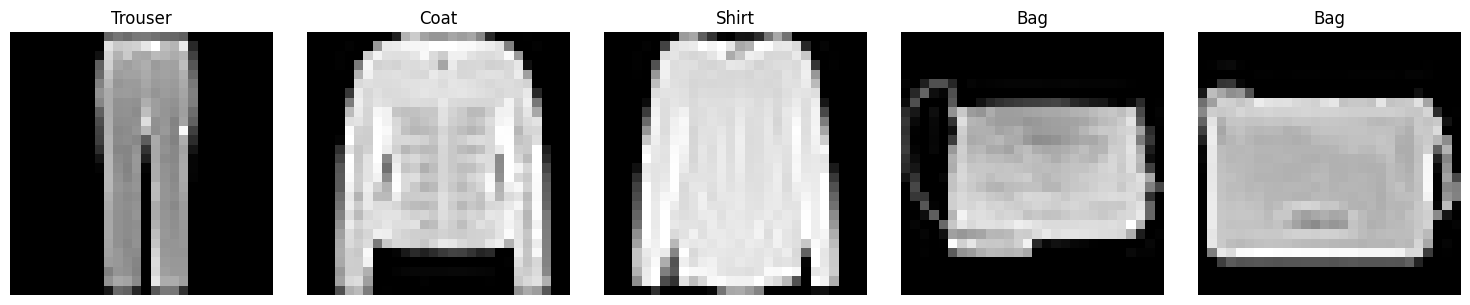


Training set distribution:

Class Distribution:
------------------
Class 0 (T-shirt/top): 4180 samples
Class 1 (Trouser): 4227 samples
Class 2 (Pullover): 4187 samples
Class 3 (Dress): 4138 samples
Class 4 (Coat): 4236 samples
Class 5 (Sandal): 4240 samples
Class 6 (Shirt): 4169 samples
Class 7 (Sneaker): 4202 samples
Class 8 (Bag): 4233 samples
Class 9 (Ankle boot): 4188 samples

Validation set distribution:

Class Distribution:
------------------
Class 0 (T-shirt/top): 588 samples
Class 1 (Trouser): 599 samples
Class 2 (Pullover): 613 samples
Class 3 (Dress): 620 samples
Class 4 (Coat): 579 samples
Class 5 (Sandal): 619 samples
Class 6 (Shirt): 588 samples
Class 7 (Sneaker): 574 samples
Class 8 (Bag): 618 samples
Class 9 (Ankle boot): 602 samples

Test set distribution:

Class Distribution:
------------------
Class 0 (T-shirt/top): 1232 samples
Class 1 (Trouser): 1174 samples
Class 2 (Pullover): 1200 samples
Class 3 (Dress): 1242 samples
Class 4 (Coat): 1185 samples
Class 5 (Sandal)

In [ ]:
def load_and_split_data():
    # Load the data
    train_data = pd.read_csv('../../data/external/fashion/fashion-mnist_train.csv')
    
    # Separate features and labels
    X = train_data.iloc[:, 1:].values
    y = train_data.iloc[:, 0].values
    
    # First split: 80% train+val, 20% test
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Second split: 70% train, 10% val (from the remaining 80%)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42)  # 0.125 of 80% is 10% of total
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# 2. Visualization function
def visualize_fashion_mnist(X, y, num_images=5):
    # Fashion MNIST labels
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    
    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(X[i].reshape(28, 28), cmap='gray')
        plt.title(class_names[y[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# 3. Print class distribution
def print_class_distribution(y):
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    
    unique, counts = np.unique(y, return_counts=True)
    print("\nClass Distribution:")
    print("------------------")
    for class_idx, count in zip(unique, counts):
        print(f"Class {class_idx} ({class_names[class_idx]}): {count} samples")


# 1. Load and split the data
X_train, X_val, X_test, y_train, y_val, y_test = load_and_split_data()
    
print("Dataset splits:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
    
# 2. Visualize some training images
print("\nVisualization of training samples:")
visualize_fashion_mnist(X_train, y_train)
    
# 3. Print class distribution for each split
print("\nTraining set distribution:")
print_class_distribution(y_train)
    
print("\nValidation set distribution:")
print_class_distribution(y_val)
    
print("\nTest set distribution:")
print_class_distribution(y_test)
    
# Print class names and their corresponding labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    
print("\nClass Labels and Their Corresponding Clothing Types:")
print("------------------------------------------------")
for idx, name in enumerate(class_names):
    print(f"Label {idx}: {name}")

### 4.2.2

In [ ]:
class CNNAutoencoder(nn.Module):
    def __init__(self):
        super(CNNAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            # First convolutional block
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),    # 28x28 -> 28x28
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                                      # 28x28 -> 14x14
            
            # Second convolutional block
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),   # 14x14 -> 14x14
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                                      # 14x14 -> 7x7
            
            # Third convolutional block
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # 7x7 -> 7x7
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                                      # 7x7 -> 3x3
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            # First deconvolutional block
            nn.ConvTranspose2d(
                128, 64,
                kernel_size=4,        
                stride=2,
                padding=1,
                output_padding=1
            ),  # 3x3 -> 7x7
            nn.ReLU(),
            
            # Second deconvolutional block
            nn.ConvTranspose2d(
                64, 32,
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1
            ),  # 7x7 -> 14x14
            nn.ReLU(),
            
            # Third deconvolutional block
            nn.ConvTranspose2d(
                32, 1,
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1
            ),  # 14x14 -> 28x28
            nn.Sigmoid()  # Output values between 0 and 1
        )
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)
    
    def forward(self, x):
        latent = self.encode(x)
        reconstructed = self.decode(latent)
        return reconstructed

### 4.2.3

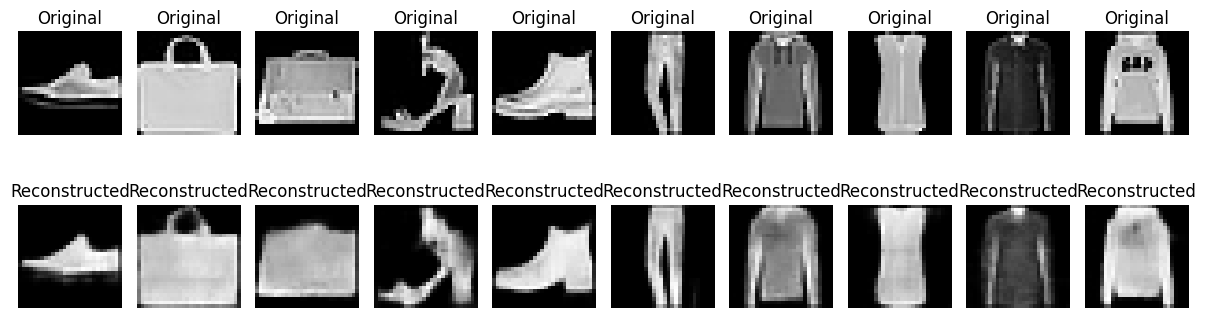

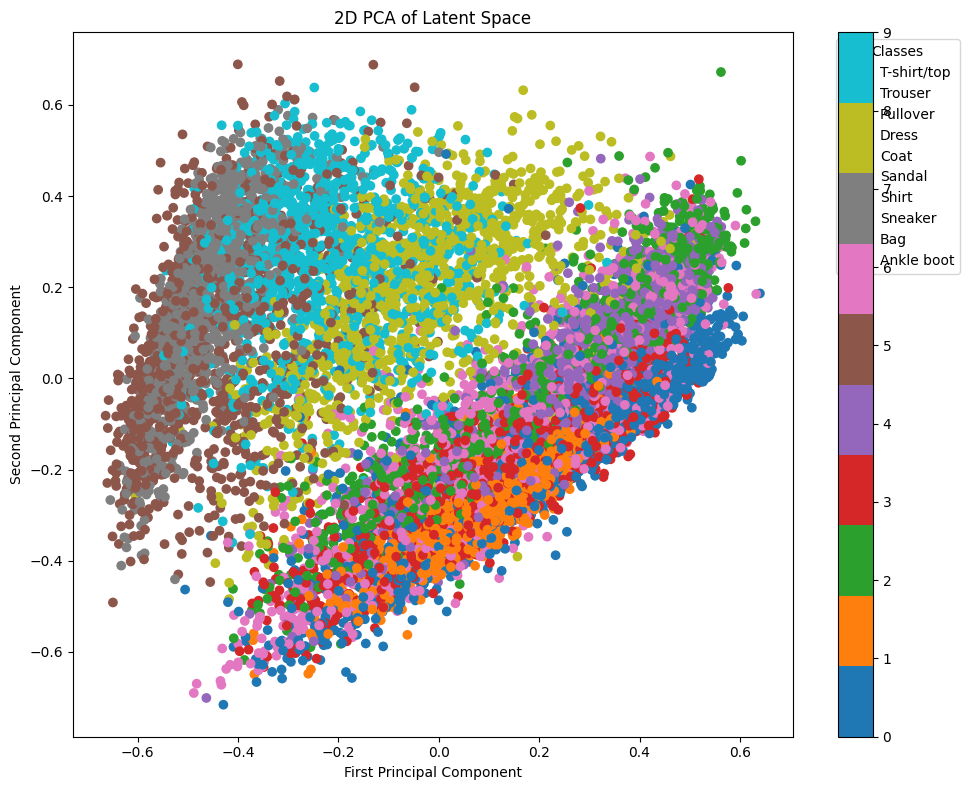

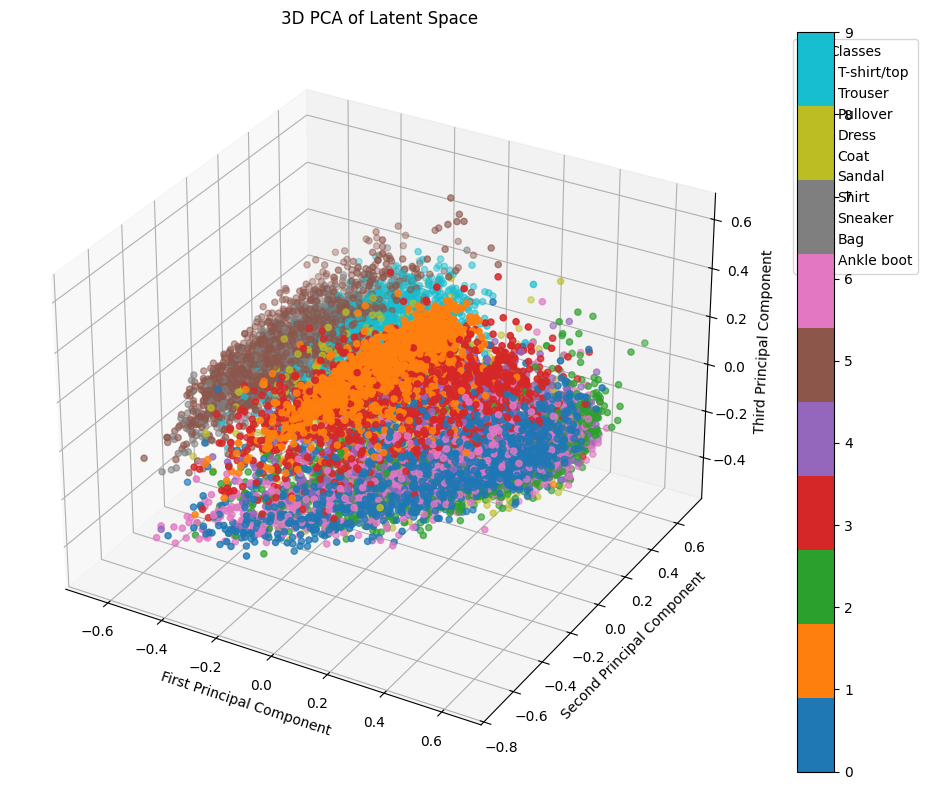

In [ ]:
class FashionMNISTDataset(Dataset):
    def __init__(self, pixels, labels):
        self.labels = torch.tensor(labels)
        self.pixels = torch.tensor(pixels / 255.0, dtype=torch.float32)
        
    def __len__(self):
        return len(self.pixels)
    
    def __getitem__(self, idx):
        image = self.pixels[idx].reshape(1, 28, 28)  # Reshape to (1, 28, 28) for CNN
        label = self.labels[idx]
        return image, label
    
def visualize_latent_space(model, test_loader, class_names):
    # Set model to evaluation mode
    model.eval()
    
    # Lists to store latent representations and labels
    latent_representations = []
    labels_list = []
    
    # Get latent representations for all test images
    with torch.no_grad():
        for images, labels in test_loader:
            # Get encoded representations
            encoded = model.encode(images)
            # Flatten the encoded representations
            encoded_flat = encoded.view(encoded.size(0), -1)
            
            latent_representations.append(encoded_flat.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
    
    # Concatenate all batches
    latent_representations = np.concatenate(latent_representations, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    
    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=3)
    latent_pca = pca.fit_transform(latent_representations)
    
    # 2D Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_pca[:, 0], latent_pca[:, 1], c=labels, cmap='tab10')
    plt.colorbar(scatter)
    plt.title('2D PCA of Latent Space')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.legend(handles=scatter.legend_elements()[0], labels=class_names, 
              title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # 3D Plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(latent_pca[:, 0], latent_pca[:, 1], latent_pca[:, 2], 
                        c=labels, cmap='tab10')
    plt.colorbar(scatter)
    ax.set_title('3D PCA of Latent Space')
    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')
    ax.set_zlabel('Third Principal Component')
    plt.legend(handles=scatter.legend_elements()[0], labels=class_names, 
              title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def visualize_reconstructions(model, test_loader, num_images=5):
    model.eval()
    with torch.no_grad():
        images, labels = next(iter(test_loader))
        images = images[:num_images].to(device)
        reconstructed, _ = model(images)

        # Plot original and reconstructed images
        fig, axes = plt.subplots(2, num_images, figsize=(12, 4))
        for i in range(num_images):
            axes[0, i].imshow(images[i].cpu().squeeze(), cmap='gray')
            axes[0, i].axis('off')
            axes[0, i].set_title('Original')

            axes[1, i].imshow(reconstructed[i].cpu().squeeze(), cmap='gray')
            axes[1, i].axis('off')
            axes[1, i].set_title('Reconstructed')
            
        plt.tight_layout()
        plt.show()



test_dataset = FashionMNISTDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
visualize_reconstructions(model, test_loader, num_images=10)

model = CNNAutoencoder()
model.eval()
visualize_latent_space(model, test_loader, class_names)

### 4.2.4

### 4.3
since my MLPAutoEncoder from the previous encoder wasn't working. So i've not done this question.

### 4.4

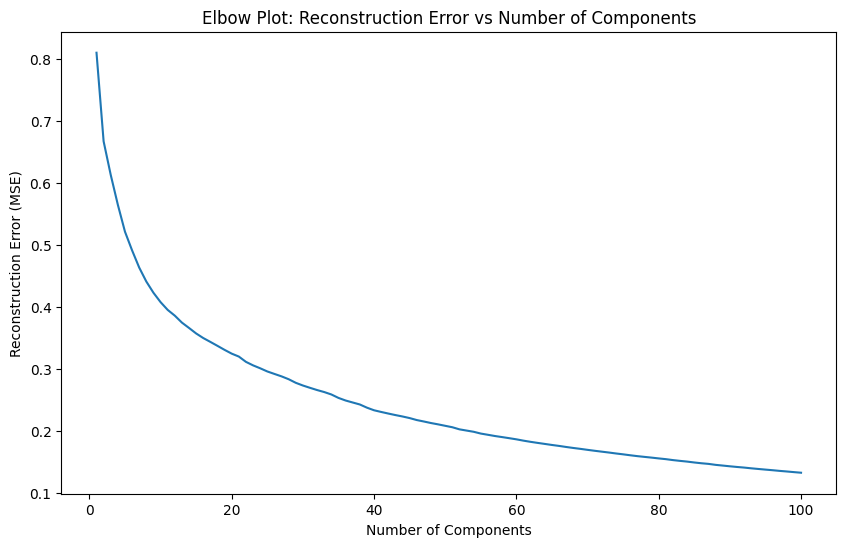

Estimated optimal number of components: 50


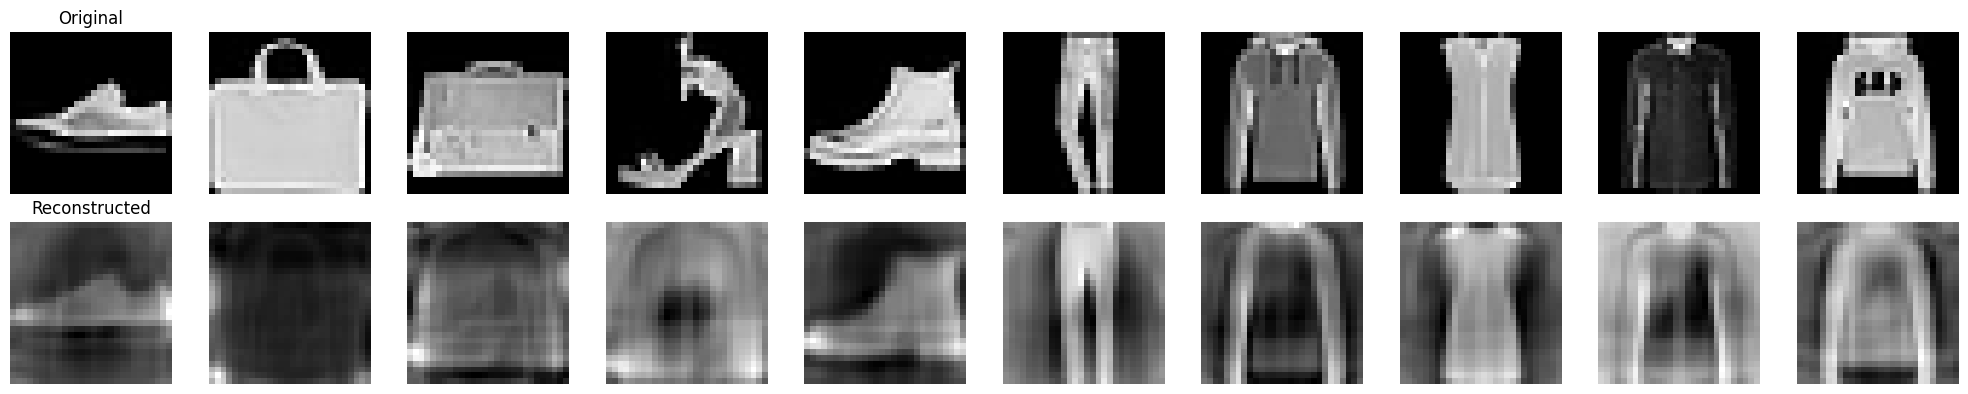

Test set reconstruction error (MSE): 0.194191


In [51]:
class PcaAutoencoder:
    def __init__(self, n_components):
        self.n_components = n_components
        self.mean = None
        self.eigenvectors = None
        
    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        
        cov_matrix = np.cov(X_centered, rowvar=False)
        
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        self.eigenvectors = eigenvectors[:, :self.n_components]
    
    def encode(self, X):
        X_centered = X - self.mean
        return np.dot(X_centered, self.eigenvectors)
    
    def forward(self, X):
        encoded = self.encode(X)
        reconstructed = np.dot(encoded, self.eigenvectors.T) + self.mean
        return reconstructed


def load_and_split_data():
    train_data = pd.read_csv('../../data/external/fashion/fashion-mnist_train.csv')
    X = train_data.iloc[:, 1:].values
    y = train_data.iloc[:, 0].values    
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = load_and_split_data()

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Define MSE loss function
def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Estimate optimal number of components
max_components = 100
reconstruction_errors = []

for n_components in range(1, max_components + 1):
    pca_ae = PcaAutoencoder(n_components)
    pca_ae.fit(X_train_scaled)
    X_val_reconstructed = pca_ae.forward(X_val_scaled)
    error = mse_loss(X_val_scaled, X_val_reconstructed)
    reconstruction_errors.append(error)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_components + 1), reconstruction_errors)
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error (MSE)')
plt.title('Elbow Plot: Reconstruction Error vs Number of Components')
plt.show()


k_optimal = 50 

print(f"Estimated optimal number of components: {k_optimal}")


pca_ae_optimal = PcaAutoencoder(k_optimal)
pca_ae_optimal.fit(X_train_scaled)


X_test_reconstructed = pca_ae_optimal.forward(X_test_scaled)


n_samples = 10
fig, axes = plt.subplots(2, n_samples, figsize=(20, 4))
for i in range(n_samples):
    # Original images
    axes[0, i].imshow(X_test[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('Original')
    
    # Reconstructed images
    axes[1, i].imshow(X_test_reconstructed[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title('Reconstructed')

plt.tight_layout()
plt.show()


test_error = mse_loss(X_test_scaled, X_test_reconstructed)
print(f"Test set reconstruction error (MSE): {test_error:.6f}")

### 4.5
